# Implementation of Vanilla, Double and Clipped Double DQN

In [1]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]

In [2]:
#!pip install "gym[accept-rom-license, atari]"
#!pip install PyVirtualDisplay

In [3]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecVideoRecorder
import random
import os, psutil 
from tqdm import tqdm
from collections import deque
import json
import time
import gc

2024-01-21 23:18:59.735266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 23:18:59.735299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 23:18:59.736641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 23:18:59.744002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 23:19:00.745180: W tensorflow/compiler/tf2

### Linear Iterator for exploration rate

In [4]:
class LinearIterator:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
    
    def value(self, step):
        return max(self.start + (self.end - self.start) * step / self.steps, self.end)

In [5]:
def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    memory_percent = psutil.virtual_memory().percent
    return np.round(memory_use, 2), np.round(memory_percent, 2)

## Experience replay buffer

In [6]:
class ExperienceReplay:
    def __init__(self, max_replay_size):
        self.max_replay_size = max_replay_size
        self.experiences = deque(maxlen=max_replay_size)

    def add_experience(self, obs, env, Q, eps):
        actions = self.get_actions(obs, env, Q, eps)

        # Made to work with only one environment because I want to use StackedFrames
        # and it doesn't work with non vectorized environments
        next_obs, rewards, dones, infos = env.step(actions)

        experiences = [(obs, action, rew, next_obs, done, info) for obs, action, rew, next_obs, done, info in zip(obs, actions, rewards, next_obs, dones, infos)]
        self.experiences.extend(experiences)

        return next_obs, rewards, dones, infos

    def get_actions(self, obs, env, Q, eps):
        n_actions = env.action_space.n
        n_env = env.num_envs
        actions = [0] * n_env
        
        for i in range(n_env):
            if eps >= random.random():
                actions[i] = random.randint(0, n_actions - 1)
            else:
                # We can also use numpy but this is more efficient
                tensor_state = tf.convert_to_tensor(obs[i])
                # Dimensions need to be expanded cause the model expects a batch/not a single element
                expanded_state = tf.expand_dims(tensor_state, axis=0)
                q_values = Q(expanded_state, training=False)[0]
                actions[i] = tf.argmax(q_values).numpy()
        
        return actions

    def sample_batch(self, batch_size):
        batch_idx = random.sample(range(0, len(self.experiences) - 1), batch_size)

        batch_state = np.array([self.experiences[idx][0] for idx in batch_idx])
        batch_action = [self.experiences[idx][1] for idx in batch_idx]
        batch_rew = [self.experiences[idx][2] for idx in batch_idx]
        batch_next_state = np.array([self.experiences[idx][3] for idx in batch_idx])
        batch_done = tf.convert_to_tensor([float(self.experiences[idx][4]) for idx in batch_idx])

        return batch_state, batch_action, batch_rew, batch_next_state, batch_done

## Custom Model

In [7]:
class CustomModel(tf.keras.Model):
    def __init__(self, n_stack, num_actions):
        super(CustomModel, self).__init__()
        self.conv1 = Conv2D(32, 8, strides=4, padding='valid', activation="relu", input_shape=(84, 84, n_stack))
        self.conv2 = Conv2D(64, 4, strides=2, padding='valid', activation="relu")
        self.conv3 = Conv2D(64, 3, strides=1, padding='valid', activation="relu")
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation="relu")
        self.dense2 = Dense(num_actions, activation="linear")

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

## Log data during training

In [8]:
class LogData:
    def __init__(self, log_file_path, lr = 0.001, n_env=1, n_stack=4):
        self.log_file = log_file_path + '/data'
        self.log_dir = log_file_path
        self.data = []
        self.initial_size = 0
        self.last_print = 0
        self.n_stack = n_stack
        self.n_env = n_env
        self.lr = lr
        self.start_time = time.time()
        self.retrieve_highest_length_saved()

    def add_episode_data(self, step, episode_infos, losses, n_updates, eps_list, episode_reward):
        current_data = {}
        current_data['score'] = episode_infos['r']
        current_data['reward'] = episode_reward
        current_data['eps'] = np.round(float(np.mean(eps_list)), 4)
        current_data['len'] = episode_infos['l']

        current_data['time'] = np.round(time.time() - self.start_time, 2)
        current_data['timesteps'] = step
        current_data['time_per_episode'] = np.round(episode_infos['t'], 2)

        cpu_stat = cpu_stats()
        current_data['cpu_memory'] = cpu_stat[0]
        current_data['cpu_percent'] = cpu_stat[1]
        
        current_data['learning_rate'] = self.lr
        current_data['loss_mean'] = np.round(float(np.mean(losses)), 2)

        current_data['n_updates'] = (n_updates + self.data[-1]['n_updates']) if len(self.data) > 1 else n_updates

        self.data.append(current_data)

    def __len__(self):
        return len(self.data)
    
    def print_statistics(self):
        print(f"{'='*28} Training Summary {'='*28}")
        print(f"Episode Length Mean: {self.ep_len_mean()}")
        print(f"Episode Reward Mean: {self.ep_rew_mean()}")
        print(f"Episode Score Mean: {self.ep_score_mean()}")
        print(f"Exploration Rate: {self.data[-1]['eps']}")
        print(f"Episodes: {self.episodes()}")
        print(f"Frame per second: {self.fps()}")
        print(f"Time Elapsed: {self.data[-1]['time']} seconds")
        print(f"Total Timesteps: {self.data[-1]['timesteps']}")
        print(f"CPU Memory Usage: {self.data[-1]['cpu_memory']} GB")
        print(f"CPU Usage: {self.data[-1]['cpu_percent']}%")
        print(f"Learning Rate: {self.data[-1]['learning_rate']}")
        print(f"Loss: {self.data[-1]['loss_mean']}")
        print(f"Num Updates: {self.data[-1]['n_updates']}")
        print('='*74)
        self.last_print = len(self.data)

        if self.data[-1]['cpu_percent'] > 80:
            print("WARNING: CPU usage is very high!")
            print("Saving data to disk and freeing memory...")
            self.save_data()

    def ep_len_mean(self, window=-1):
        if window == -1:
            window = len(self.data) - self.last_print
        
        mean = np.mean([data['len'] for data in self.data[-window:]])
        return int(mean)

    def ep_rew_mean(self, window=-1):
        if window < 0:
            window = len(self.data) - self.last_print

        return int(np.mean([data['reward'] for data in self.data[-window:]]))

    def ep_score_mean(self, window=-1):
        if window < 0:
            window = len(self.data) - self.last_print

        return int(np.mean([data['score'] for data in self.data[-window:]]))

    def episodes(self):
        return len(self.data) + self.initial_size

    def fps(self, window=-1):
        if window == -1:
            window = len(self.data) - self.last_print
            
        frames = (self.data[-1]['timesteps'] - self.data[-window]['timesteps']) * self.n_env * self.n_stack
        seconds = self.data[-1]['time'] - self.data[-window]['time']
        return int(np.round(frames / seconds))
    
    def save_data(self):
        final_len = self.last_print + self.initial_size
        remain_len = len(self.data) - self.last_print
        self.last_print = 0 

        if remain_len == 0:
            remain_len = 1
            final_len -= 1
            self.last_print += 1

        if final_len == 0:
            return
        
        self.initial_size = final_len
        
        file_path = f"{self.log_file}_{final_len}.json"

        if os.path.exists(file_path):
            return

        with open(file_path, 'w') as file:
            json.dump(self.data[:-remain_len], file)
        
        self.data = self.data[-remain_len:]
        
        gc.collect()

    @staticmethod
    def load_data(log_file_path):
        try:
            with open(log_file_path, 'r') as file:
                data = json.load(file)
        except FileNotFoundError:
            # Handle the case where the file does not exist
            data = []
        return data
    
    def retrieve_highest_length_saved(self):
        # Get a list of all files in the current directory
        files = [f for f in os.listdir(self.log_dir) if f.startswith("data_") and f.endswith(".json")]

        # Check if any files match the pattern
        if files:
            # Find the file with the highest length in its name
            highest_length_file = max(files, key=lambda x: int(x[len("data_"):].split('.')[0]))
            filename = self.log_dir + "/" + highest_length_file
            self.initial_size = int(highest_length_file[len("data_"):].split('.')[0])

            self.data = self.load_data(filename)
            
            if len(self.data) > 1:
                os.remove(filename)
                self.last_print = len(self.data)
                self.initial_size -= len(self.data) 
                self.save_data()
                
            gc.collect()
        else:
            self.initial_size = 0


## DQNmodel Class implementation

In [9]:
class DQNmodel:
    def __init__(self,
                save_model_to: str = "./Q_model",
                load_model_from: str = None,
                checkpoint_dir: str = "./checkpoints",
                env_path: str = "ALE/MsPacman-v5",
                dqn_type: str = "vanilla",
                n_stack: int = 4,
                n_env: int = 1,
                learning_rate: float = 0.00025,
                buffer_size: int = 100000,
                learning_starts: int = 10000,
                batch_size: int = 32,
                tau: float = 1.0,
                gamma: float = 0.99,
                update_target_Q_every_n_steps: int = 10000, 
                save_checkpoint_every_n_steps: int = 100000,
                log_every_n_episodes: int = 50,
                exploration_fraction: float = 0.4,
                exploration_initial_eps: float = 1.0,
                exploration_final_eps: float = 0.2,
                max_grad_norm: float = 10,
                avoid_finish_episode: bool = True,
                record: bool = False,
                video_path: str = "./video"
                 ):
        self.save_model_to = save_model_to
        self.checkpoint_dir = checkpoint_dir
        
        self.dqn_type = dqn_type
        if self.dqn_type in ["vanilla", "double", "clipped_double"]:        
            self.save_model_to += "_" + self.dqn_type
        else:
            raise ValueError("Invalid DQN type: " + self.dqn_type + ". Valid types are: vanilla, double, dueling, noisy")
        
        # Create the directory if it doesn't exist
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        self.env_path = env_path
        self.n_env = n_env
        self.n_stack = n_stack
        self.learning_rate = learning_rate
        self.buffer_size = buffer_size
        self.learning_starts = learning_starts
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.update_target_Q_every_n_steps = update_target_Q_every_n_steps
        self.save_checkpoint_every_n_steps = save_checkpoint_every_n_steps
        self.log_every_n_episodes = log_every_n_episodes
        self.exploration_fraction = exploration_fraction
        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.max_grad_norm = max_grad_norm
        self.avoid_finish_episode = avoid_finish_episode
        self.record = record
        self.video_path = video_path

        # Initialize models
        self.Q_online = CustomModel(self.n_stack, self.num_actions)
        self.Q_target = CustomModel(self.n_stack, self.num_actions)

        # Initialize training
        self.train_fn = self._get_train_fn()
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate, clipnorm=self.max_grad_norm)
        self.loss_function = tf.keras.losses.Huber()
            
        self.checkpoint = tf.train.Checkpoint(step = tf.Variable(0), episode = tf.Variable(0), optimizer=self.optimizer, model=self.Q_target, model_online=self.Q_online)
        
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.checkpoint_dir, max_to_keep=1)

        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print("Restored from {}".format(self.checkpoint_manager.latest_checkpoint))
        
        # Initialize buffer
        self.experience_replay = ExperienceReplay(self.buffer_size)

        # Initialize logs
        self.log = LogData(self.checkpoint_dir, self.learning_rate, self.n_env, self.n_stack)

        # Load model if needed
        if load_model_from is not None: 
            self.Q_target = self.load_model(load_model_from)
        else:
            self.Q_online.set_weights(self.Q_target.get_weights())
    
    def _get_train_fn(self):
        @tf.function
        def train_function(batch_state, action_mask, target_q_values):
            # Optimize the policy
            with tf.GradientTape() as tape:
                # Get current Q-values estimates
                current_q_values = self.Q_online(batch_state, training=True)

                current_q_values = tf.reduce_sum(tf.multiply(current_q_values, action_mask), axis=1)

                loss = self.loss_function(target_q_values, current_q_values)

            grads = tape.gradient(loss, self.Q_online.trainable_variables)
            
            # Clip gradient norm
            grads = [tf.clip_by_norm(g, self.max_grad_norm) for g in grads if g is not None]
            self.optimizer.apply_gradients(zip(grads, self.Q_online.trainable_variables))

            return loss

        return train_function
    
    def train(self, total_timesteps):
        # Initialize experience replay
        eps_it = LinearIterator(self.exploration_initial_eps, self.exploration_final_eps, total_timesteps * self.exploration_fraction)

        # Initialize device
        if tf.config.list_physical_devices('GPU'):
            print("GPU is available")
            device = '/GPU:0'
        else:
            print("GPU is not available, using CPU instead")
            device = '/CPU:0'

        with tf.device(device):

            if int(self.checkpoint.step) == 0:
                print("\nStarting training from scratch")
            else:
                print("\nResuming training from step", int(self.checkpoint.step))

            obs = self.restart_env()

            if int(self.checkpoint.step) > total_timesteps:
                print("\nTraining already finished for this model and checkpoint")
                print("Training steps:", total_timesteps)
                print("Step count:", int(self.checkpoint.step))
                return
            
            # Initial Warm Up
            print("Initial warm up:", self.learning_starts, "steps")
            pbar = tqdm(range(self.learning_starts), desc="Warm up", unit="step")
            for count in pbar:
                eps = eps_it.value(count)
                next_obs, _, dones, _ = self.experience_replay.add_experience(obs, self.env, self.Q_online, eps)
                obs = next_obs
            pbar.close()
    
            episode_reward = 0
            losses = []
            n_updates = 0
            eps_list = []

            remaining_episodes_until_log = self.log_every_n_episodes - int(self.checkpoint.episode % self.log_every_n_episodes)
            pbar = tqdm(total = remaining_episodes_until_log, desc="Training", unit="episode")
            
            # Training
            while int(self.checkpoint.step) < total_timesteps:
                
                # New Experience
                eps = eps_it.value(int(self.checkpoint.step))
                next_obs, rewards, dones, infos = self.experience_replay.add_experience(obs, self.env, self.Q_online, eps)
                eps_list.append(eps)
                episode_reward += sum(rewards)

                # Sample a batch from the experience replay
                batch_state, batch_action, batch_rew, batch_next_state, batch_done = self.experience_replay.sample_batch(self.batch_size)

                # one hot encoded actions
                action_mask = tf.one_hot(batch_action, self.num_actions)
                
                if self.dqn_type == "vanilla":
                    # Compute the next Q-values using the target network
                    next_q_values_target = self.Q_target(batch_next_state, training=False)
                    
                    # Follow greedy policy: use the one with the highest value
                    next_q_values = tf.reduce_max(next_q_values_target, axis=1)

                elif self.dqn_type == "double":
                    # Compute the next Q-values using the online network
                    next_q_values_online = self.Q_online(batch_next_state, training=False)

                    # Follow greedy policy: use the action with the highest value
                    next_actions_online = tf.argmax(next_q_values_online, axis=1)

                    # Compute the next Q-values using the target network
                    next_q_values_target = self.Q_target(batch_next_state, training=False)

                    # Choose the Q-values of the actions chosen by the online network
                    next_q_values_target_best_actions = tf.reduce_sum(tf.one_hot(next_actions_online, self.num_actions) * next_q_values_target, axis=1, keepdims=True)

                    next_q_values = next_q_values_target_best_actions
                    
                elif self.dqn_type == "clipped_double":
                    # calculate both networks values
                    next_q_values_online = self.Q_online(batch_next_state, training=False)
                    next_q_values_target = self.Q_target(batch_next_state, training=False)

                    # Follow greedy policy: use the higher values
                    max_next_q_values_online = tf.reduce_max(next_q_values_online, axis=1)
                    max_next_q_values_target = tf.reduce_max(next_q_values_target, axis=1)

                    # calculate the minimum of the two networks values
                    next_q_values = tf.minimum(max_next_q_values_online, max_next_q_values_target)
                
                if self.avoid_finish_episode:
                    # 1-step TD target
                    target_q_values = batch_rew + (1 - batch_done) * self.gamma * next_q_values - batch_done
                else:
                    # 1-step TD target
                    target_q_values = batch_rew + (1 - batch_done) * self.gamma * next_q_values

                # Train the model
                loss = self.train_fn(batch_state, action_mask, target_q_values)
                    
                losses.append(loss.numpy())

                for i in range(self.n_env):
                    if dones[i]:
                        if infos[i]['lives'] == 0 or infos[i]['TimeLimit.truncated']:
                            pbar.update(1)
                            self.checkpoint.episode.assign_add(1)
                            
                            self.log.add_episode_data(int(self.checkpoint.step), infos[i]['episode'], losses, n_updates, eps_list, episode_reward)
                            losses = []
                            n_updates = 0
                            eps_list = []
                            episode_reward = 0

                            # Logs depend on episodes
                            if int(self.checkpoint.episode) % self.log_every_n_episodes == 0:
                                self.log.print_statistics()
                                pbar.close()
                                pbar = tqdm(total=self.log_every_n_episodes, desc="Training", unit="episode")
                    else:
                        obs[i] = next_obs[i]
                
                self.checkpoint.step.assign_add(1)

                # Update the target network
                if int(self.checkpoint.step) % self.update_target_Q_every_n_steps == 0:
                    new_weights = [(1 - self.tau) * target + self.tau * online for target, online in zip(self.Q_target.get_weights(), self.Q_online.get_weights())]
                    self.Q_target.set_weights(new_weights)
                    gc.collect()
                    n_updates += 1

                # Save checkpoint                   
                if int(self.checkpoint.step) % self.save_checkpoint_every_n_steps == 0:
                    # Save checkpoint
                    self.checkpoint_manager.save()
                    self.log.save_data()
                    gc.collect()

            self.log.print_statistics()
            
            # Training finished, save the model      
            print("Saving model and logs")          
            self.save_model()
            self.checkpoint_manager.save()
            self.log.save_data()
            print("Training finished")
        
    def predict(self, obs):
        if self.env is None:
            self.restart_env()
        return self.experience_replay.get_actions(obs, self.env, self.Q_target, self.exploration_final_eps)
    
    def env_step(self, action):
        if self.env is None:
            self.restart_env()
        return self.env.step(action)

    def restart_env(self):
        # reinitialize environment
        env = make_atari_env(self.env_path, n_envs = self.n_env)
        env = VecFrameStack(env, self.n_stack)
        if self.record:
            env = VecVideoRecorder(env, video_folder = self.video_path, record_video_trigger=lambda x: x == 0, video_length=1000, name_prefix="dqn-agent")

        self.env = env
        self.num_actions = self.env.action_space.n
        return self.env.reset()
    
    def render_env(self):
        if self.env is None:
            self.restart_env()
        return self.env.render()
    
    def close(self):
        if self.env is None:
            return
        self.env.close()

    def save_model(self):
        self.Q_target.save(self.save_model_to)

    @staticmethod
    def load_model(model_path):
        try:
            model = tf.keras.models.load_model(model_path)
            print("Model loaded")
            return model
        except:
            print("No model found")

In [10]:
model_type = "vanilla"
model_details = "_final"

model_path = f"./{model_type}_DQN/model{model_details}"
checkpoint_dir = f"./{model_type}_DQN/checkpoints{model_details}"

DQNmodel = DQNmodel(
                    save_model_to=model_path,
                    checkpoint_dir=checkpoint_dir,
                    env_path="ALE/MsPacman-v5",
                    dqn_type= model_type
                )
DQNmodel.train(total_timesteps=1000000)
#DQNmodel.close()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
2024-01-21 23:19:12.181763: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Restored from ./vanilla_DQN/checkpoints_avoid_finish_10000_update/ckpt-11


In [11]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image

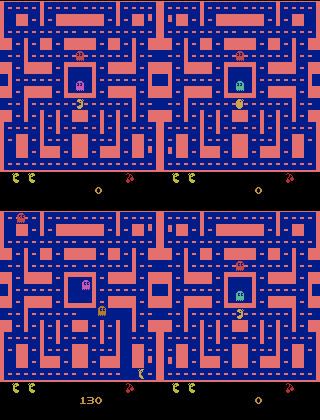

In [12]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

n_env = DQNmodel.n_env

data = {i: [[]] for i in range(n_env)}
lives = {i: 0 for i in range(n_env)}

obs = DQNmodel.restart_env()

while True:
    actions = DQNmodel.predict(obs)
    obs, rewards, dones, infos = DQNmodel.env_step(actions)
    
    for i in range(n_env):
        if lives[i] < 3:
            if lives[i] >= len(data[i]):
                data[i].append([])
            
            data[i][lives[i]].append(rewards[i])

            if 'episode' in infos[i]:
                data[i].append([infos[i]['episode']['r'],
                                infos[i]['episode']['l'],
                                infos[i]['episode']['t']
                                ])
            if dones[i]:
                lives[i] += 1

    # Render the environment and display the frame
    screen = DQNmodel.render_env()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    # Wait time to watch the game 
    #time.sleep(1/4)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([lives[i] >= 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
DQNmodel.close()

In [15]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

episodes = 3

for i in range(n_env):
    for j in range(episodes):
        copy_data[i][j] = [np.sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)

for i in range(n_env):
    
    print("Total episodes for CPU", i, ":", episodes-1)
    print("Total reward :", sum([copy_data[i][j][0] for j in range(episodes)]), "with average reward", format(sum([copy_data[i][j][0] for j in range(episodes)])/episodes, '.2f'))
    print('Total points :', copy_data[i][-1][0])
    print('Total len :', copy_data[i][-1][1])
    print('Total time :', copy_data[i][-1][2])
    print("Total steps :", sum([copy_data[i][j][1] for j in range(episodes)]), "with average steps", format(sum([copy_data[i][j][1] for j in range(episodes)])/episodes, '.2f'))
    print("Weighted average reward :", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(episodes)])/sum([copy_data[i][j][1] for j in range(episodes)]), '.2f'))
    print()

print("Total episodes:", sum([episodes for i in range(n_env)]))

{0: [[50.0, 94], [37.0, 79], [16.0, 42], [2880.0, 871, 69.34474]],
 1: [[47.0, 111], [7.0, 29], [22.0, 67], [1340.0, 851, 66.535565]],
 2: [[18.0, 36], [36.0, 69], [38.0, 85], [1490.0, 783, 60.963783]],
 3: [[43.0, 83], [30.0, 57], [26.0, 71], [2050.0, 865, 67.570556]]}
Total episodes for CPU 0 : 2
Total reward : 103.0 with average reward 34.33
Total points : 2880.0
Total len : 871
Total time : 69.34474
Total steps : 215 with average steps 71.67
Weighted average reward : 38.58

Total episodes for CPU 1 : 2
Total reward : 76.0 with average reward 25.33
Total points : 1340.0
Total len : 851
Total time : 66.535565
Total steps : 207 with average steps 69.00
Weighted average reward : 33.30

Total episodes for CPU 2 : 2
Total reward : 92.0 with average reward 30.67
Total points : 1490.0
Total len : 783
Total time : 60.963783
Total steps : 190 with average steps 63.33
Weighted average reward : 33.48

Total episodes for CPU 3 : 2
Total reward : 99.0 with average reward 33.00
Total points : 205